In [4]:
#Array packages

import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
import cartopy.feature as cfeature
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


#Trend
import xarrayMannKendall as XMK
import dask
from dask import delayed
import graphviz


import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow


### Trend seasonal 

In [5]:
ds=xr.open_mfdataset(f'3_Data/Data_p/1_ILDAS/ILDAS_station_indices.nc')

index=['fld_flow','drt_flow']
station=ds.station.values
index=['fld_flow','drt_flow']
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
MK=['slope','p_value']

d_arr1=xr.DataArray(coords={'index':index,'station':station,'season':ssn},dims=['index','station','season'],name='trend')
d_arr2=xr.DataArray(coords={'index':index,'station':station,'season':ssn},dims=['index','station','season'],name='p_value')
ds_mk=xr.Dataset({'trend':d_arr1,'p_value':d_arr2})


result=[]
trnd = pd.DataFrame(index= station)
for stn in station:
    for ind in index:
        for ss in ssn:

            data1=ds[ind].sel(station=stn,season=ss).values
            trend1, h1, p1, z1, Tau1, s1, var_s1, slope1, intercept1 = mk.original_test(data1)
            ds_mk['trend'].loc[{'index': ind, 'station': stn, 'season': ss}] =(slope1/np.nanmean(data1))*1000
            ds_mk['p_value'].loc[{'index': ind, 'station': stn, 'season': ss}] = p1

ds_mk.to_netcdf(r'2_Streamflow_Analysis\3_Trend analysis\output\ILDAS_indices_trend.nc')


ValueError: Length of values (260) does not match length of index (241)

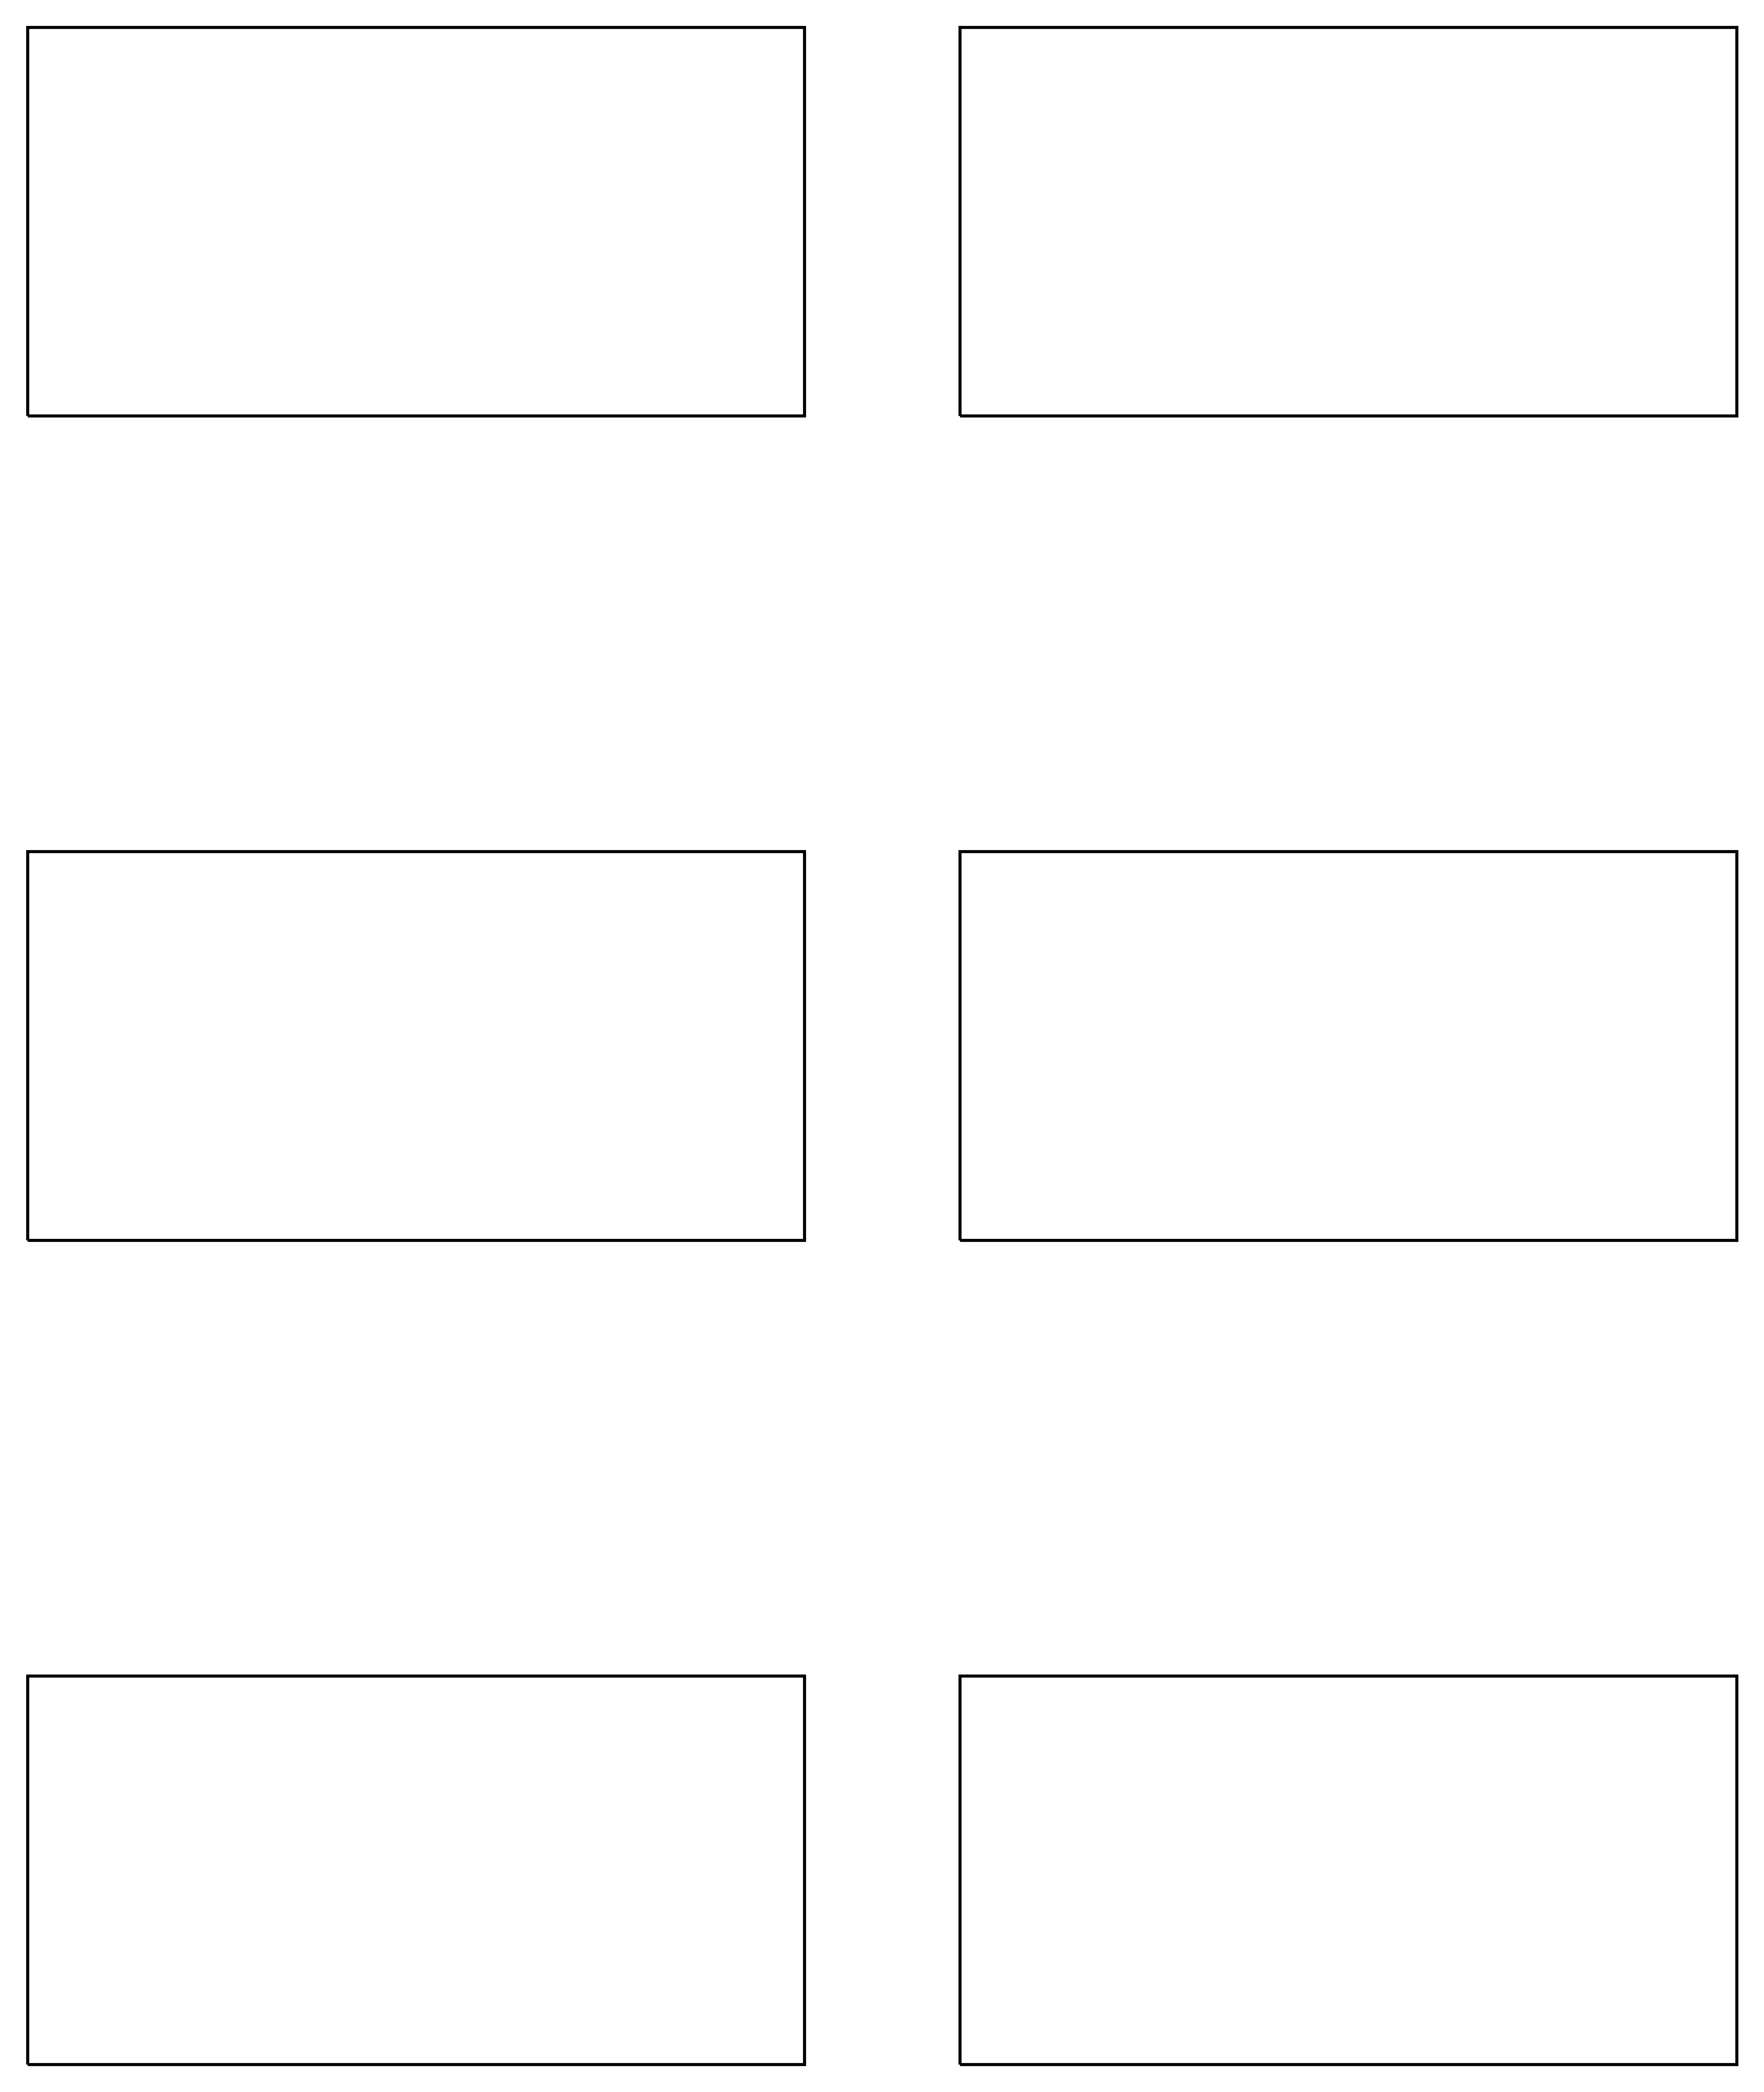

In [6]:
import scienceplots
#plt.style.use(['science','no-latex','bright'])
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [  'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']
plt.rcParams['font.family'] = 'Times New Roman'

from matplotlib.colors import BoundaryNorm
num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35


# Loading maps
guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

basin_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')



fig, ax1 = plt.subplots(3, 2, figsize=(8,11), subplot_kw={"projection": ccrs.PlateCarree()},dpi=1000)
ax1=ax1.flatten()
i=0
ssn=['Pre-monsoon','Monsoon','Post-monsoon']
for ss in ssn:
    for id,ind in enumerate(index):

        guage_info['trend']=ds_mk['trend'].loc[{'index': ind, 'season': ss}]
        guage_info['p_value']=ds_mk['p_value'].loc[{'index': ind, 'season': ss}]
        guage_info['edge']=np.where(guage_info['p_value']<0.05,0.7,0)
        #Axis setting
        [x.set_visible(False) for x in ax1[i].spines.values()]
        [x.set_linewidth(0.1) for x in ax1[i].spines.values()]


        #####Plot#####
        cmap1='RdBu'
        levels = [-25,-12,-6,-2,0,2,6,12,25]
        cmap = plt.get_cmap(cmap1)
        #norm = PowerNorm(gamma=0.5, vmin=min(levels), vmax=max(levels)) 
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        south_asia.plot(ax=ax1[i],color = 'none',edgecolor = basinEdge,linewidth=basinLine,alpha=0.9)
        #ind_map.plot(ax=ax1[i],color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
        #riv_map.plot(ax=ax1[i],color = 'blue',alpha=0.8,linewidth=basinLine*0.1)
        #xrr2['trend'].plot(ax=ax1[i],cmap='RdBu',vmin=-0.02,vmax=0.02)

        c1=np.repeat(['white'],len(guage_info['Latitude']))
        sc=ax1[i].scatter(guage_info['Longitude'],guage_info['Latitude'],c=guage_info['trend'],s=12,cmap=cmap1,norm=norm)
        # Add gridlines and titles for better readability


        ## Texts
        ax1[i].text(0.65, 0.9, ['Flood flow','Drought flow'][id], fontsize=9, color='black',fontname='Times New Roman',weight='bold',
             transform=ax1[i].transAxes, ha='center', va='center')

        if ind==index[0]:
            ax1[i].text(-0.1, 0.5, ss, fontsize=12, color='black',fontname='Times New Roman',rotation=90,weight='bold',
              transform=ax1[i].transAxes,ha='center', va='center')

        # Adjust the location of the subplots on the page to make room for the colorbar
        fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.1, hspace=0.01)  


        if ind==index[0]:

            ##### colorbar #######
            lf=ax1[i].get_position().x0
            bt=ax1[i].get_position().y0
            wd=ax1[i].get_position().width
            hg=ax1[i].get_position().height
            cbar_ax = fig.add_axes([lf+wd*1.05, bt + 0.074, 0.01,hg-hg*0.6])
            cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', fraction=0.036, pad=0.04)
            cbar.set_label('Slope')

            cbar.outline.set_linewidth(0.5) 
            cbar.ax.tick_params(axis='both',which='both', labelsize=7,width=2, length=0) 
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label("Change (% per decade)", fontsize=7, labelpad=6)
            #cbar.ax.xaxis.label.set_fontweight('bold')

            # Customize tick labels
            #ticks = [-10,0, 10]
            #cbar.set_ticks(ticks)
            #cbar.set_ticklabels([str(tick) for tick in ticks])
        #plt.tight_layout()
        i=i+1
plt.savefig(r'2_Streamflow_Analysis\3_Trend analysis\output\ILDAS_indices_trend.jpeg', bbox_inches='tight',dpi=1000)

## PLOT2 : Accelerating/ Decelerating

In [19]:
matrix = np.array([[1, 2,3,3],
                   [1,2,3,3],
                   [0,1,2,2],
                   [0,0,1,1]])
bl=matrix;gr=np.flip(matrix, axis=0);rd=np.transpose(matrix);pr=np.flip(matrix, axis=1)
C=np.block([[pr, bl],
        [rd, gr]])

import matplotlib.colors as mcolors
col_list=[]
col=['Blues','Purples','Reds','Greens']
for i in range(4):
    cmap = plt.cm.get_cmap(col[i], 30)  # Choose a colormap and number of colors
    colors = [cmap(i) for i in [0,3,18,28]]
    # Convert colors to hexadecimal codes
    hex_colors = np.array([mcolors.to_hex(color) for color in colors])
    col_list.append(hex_colors)

bl1=col_list[0][matrix]
gr1=np.flip(col_list[1][matrix], axis=0)
rd1=np.transpose(col_list[2][matrix])
pr1=np.flip(col_list[3][matrix], axis=1)

col_map = np.block([[pr1, bl1],
                    [rd1, gr1]])




C:\Users\sstar\AppData\Local\Temp\ipykernel_6388\3650803368.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(col[i], 30)  # Choose a colormap and number of colors


C:\Users\sstar\AppData\Local\Temp\ipykernel_6388\280177123.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))
C:\Users\sstar\AppData\Local\Temp\ipykernel_6388\280177123.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))
C:\Users\sstar\AppData\Local\Temp\ipykernel_6388\280177123.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))
C:\Users\sstar\AppData\Local\Temp\ipykernel_6388\280177123.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result[['row','col']] = result[['

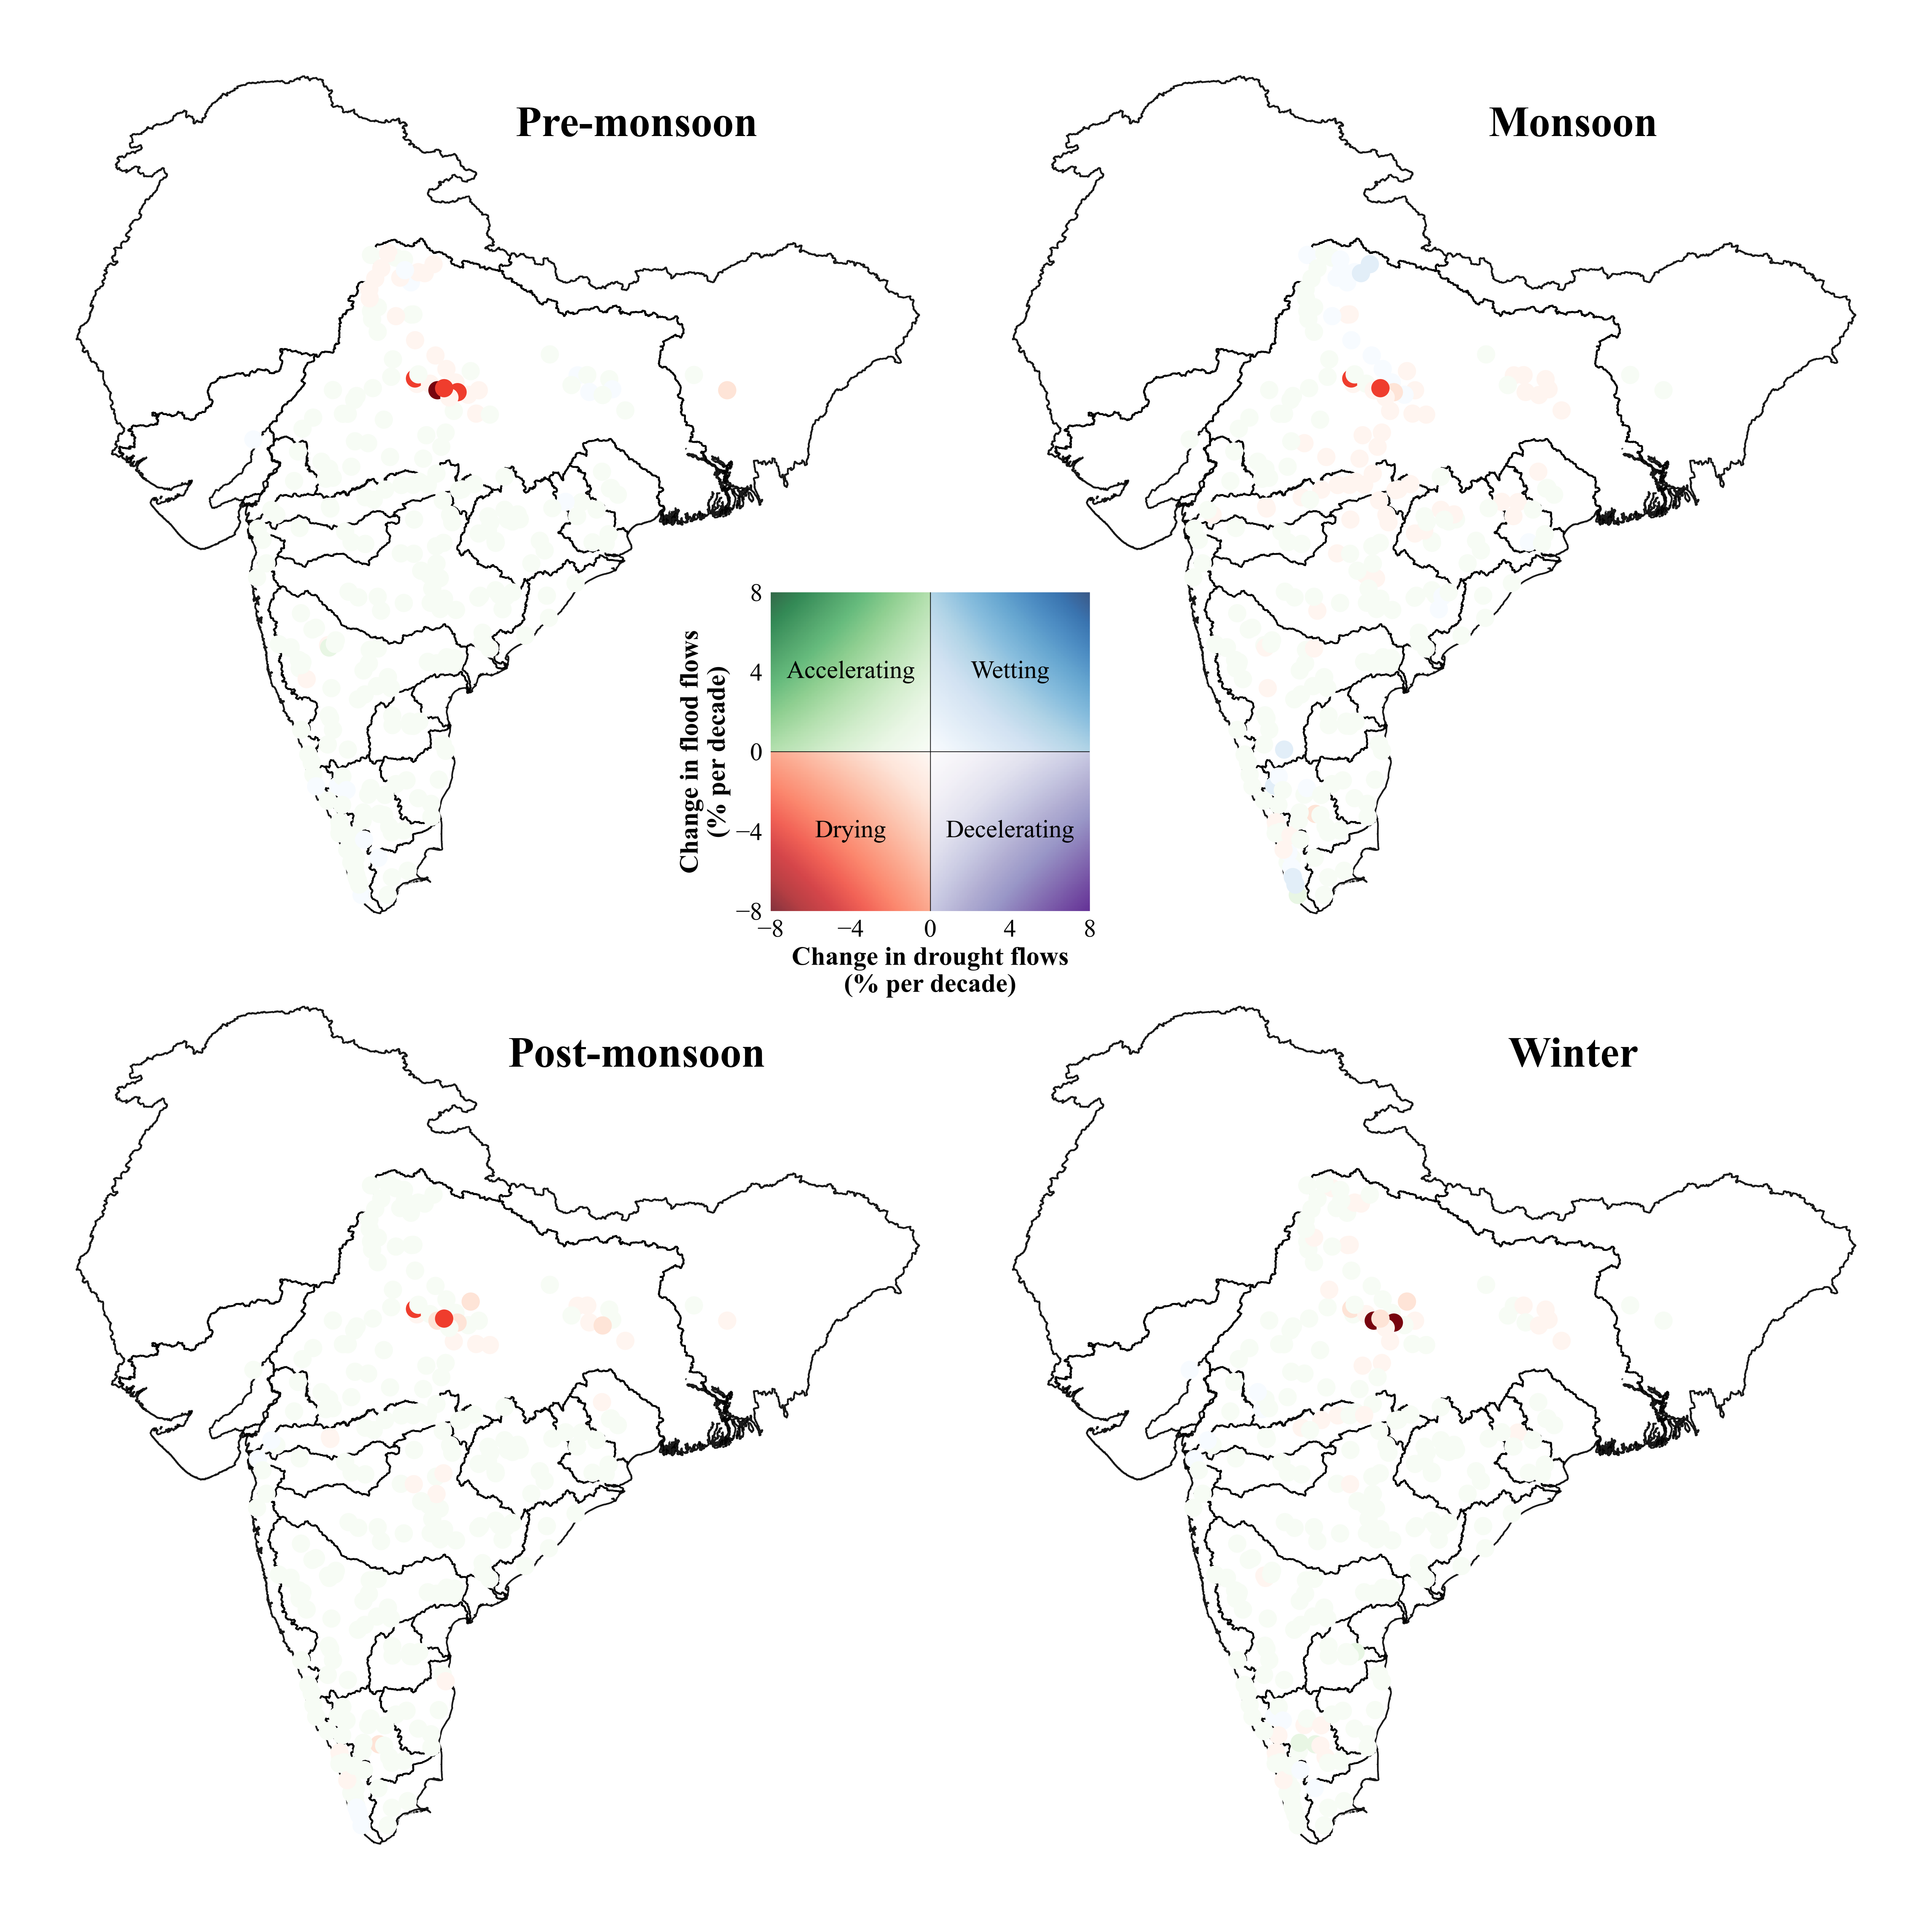

In [22]:
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.image as mpimg

fig, ax1 = plt.subplots(2, 2, figsize=(7,7), subplot_kw={"projection": ccrs.PlateCarree()},dpi=1000)
ax1=ax1.flatten()
i=0
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']


for ss in ssn:

    fl=ds_mk.loc[{'index': index[0], 'season': ss}].to_dataframe().drop('index',axis=1)
    fl.rename(columns={'trend':'tr_fld','p_value':'p_fld'},inplace=True)

    dr=ds_mk.loc[{'index': index[1], 'season': ss}].to_dataframe().drop('index',axis=1)
    dr.rename(columns={'trend':'tr_drt','p_value':'p_drt'},inplace=True)
    result=dr.join(fl, lsuffix='_df1', rsuffix='_df2')
    result['tr_fld'].max()


    scaler = MinMaxScaler(feature_range=(-4, 4))
    scaler.fit(np.arange(-30,30,0.1).reshape(-1, 1))

    result[['tr_drt','tr_fld']]=result[['tr_drt','tr_fld']].applymap(lambda p : p if (-30 < p <30) else math.copysign(29, p))

    result[['row','col']] = result[['tr_fld','tr_drt']].applymap(lambda p: int(np.array(scaler.transform([[p]])).reshape(-1)))

    result['col'] = result['col'].apply(lambda p: int(1.1667*p+3.5))
    result['row'] = result['row'].apply(lambda p: int(-1.1667*p+3.5))

    result['color']=col_map[result['row'],result['col']]

    #Axis setting
    [x.set_visible(False) for x in ax1[i].spines.values()]
    [x.set_linewidth(0.1) for x in ax1[i].spines.values()]


    #####Plot#####

    south_asia.plot(ax=ax1[i],color = 'none',edgecolor = basinEdge,linewidth=basinLine,alpha=0.9)
    #ind_map.plot(ax=ax1[i],color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
    #riv_map.plot(ax=ax1[i],color = 'blue',alpha=0.8,linewidth=basinLine*0.1)
    #xrr2['trend'].plot(ax=ax1[i],cmap='RdBu',vmin=-0.02,vmax=0.02)

    c1=np.repeat(['white'],len(guage_info['Latitude']))
    sc=ax1[i].scatter(guage_info['Longitude'],guage_info['Latitude'],c=result['color'],s=8)
    # Add gridlines and titles for better readability


    ## Texts
    ax1[i].text(0.65, 0.9, ss, fontsize=9, color='black',fontname='Times New Roman',weight='bold',
            transform=ax1[i].transAxes, ha='center', va='center')

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.01, hspace=0.01)  

    i=i+1

legend_img = mpimg.imread(r'2_Streamflow_Analysis\3_Trend analysis\legend1.png')
left, bottom, width, height = 0.65, 0.1, 0.3, 0.3
ax_legend = fig.add_axes([0.39, 0.475, 0.18, 0.18], anchor='NE', zorder=5)
ax_legend.imshow(legend_img)
ax_legend.axis('off')   
plt.savefig(r'2_Streamflow_Analysis\3_Trend analysis\output\ILDAS_indices_classification.jpeg', bbox_inches='tight',dpi=1000)

C:\Users\sstar\AppData\Local\Temp\ipykernel_19912\369055284.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', 5)  # Choose a colormap and number of colors


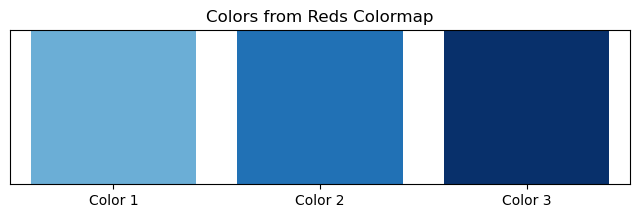

In [78]:
import matplotlib.colors as mcolors
cmap = plt.cm.get_cmap('Blues', 5)  # Choose a colormap and number of colors
colors = [cmap(i+2) for i in range(3)]
hex_colors = [mcolors.to_hex(color) for color in colors]
hex_colors



# Plotting
fig, ax = plt.subplots(figsize=(8, 2))
for i, color in enumerate(hex_colors):
    ax.bar(i, 1, color=color)

# Customize plot
ax.set_xlim(-0.5, len(hex_colors)-0.5)
ax.set_ylim(0, 1)
ax.set_xticks(range(len(hex_colors)))
ax.set_xticklabels(['Color 1', 'Color 2', 'Color 3'])  # Replace with meaningful labels
ax.set_yticks([])  # Hide y-axis ticks
ax.set_title('Colors from Reds Colormap')

plt.show()

### checks

In [ ]:

from pykrige.ok import OrdinaryKriging

num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35


# Loading maps
guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

basin_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')



lat = guage_info['Latitude'].values
lon = guage_info['Longitude'].values
slope = trnd['slope'].values
# Define the grid for interpolation
grid_lon = np.linspace(lon.min(), lon.max(), 40)
grid_lat = np.linspace(lat.min(), lat.max(), 40)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
# Perform Ordinary Kriging
OK = OrdinaryKriging(lon, lat, slope, variogram_model='linear', verbose=False, enable_plotting=False)
z, ss = OK.execute('grid', grid_lon, grid_lat)




fig, ax1[i] = plt.subplots(1, 1, figsize=(5,5), subplot_kw={"projection": ccrs.PlateCarree()})

south_asia.plot(ax=ax1[i],color = 'none',edgecolor = basinEdge,linewidth=basinLine*0.5,alpha=0.7)
ind_map.plot(ax=ax1[i],color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
riv_map.plot(ax=ax1[i],color = 'blue',alpha=0.8,linewidth=basinLine*0.1)
#xrr2['trend'].plot(ax=ax1[i],cmap='RdBu',vmin=-0.02,vmax=0.02)

# Plot the Kriging interpolation results
c = ax1[i].contourf(grid_lon, grid_lat, z, cmap='RdBu', alpha=0.6)

c1=np.repeat(['white'],len(guage_info['Latitude']))
sc=ax1[i].scatter(trnd['lon'],trnd['lat'],c=trnd['slope'],s=10,cmap='RdBu')
# Add gridlines and titles for better readability

cbar = plt.colorbar(sc, ax=ax1[i], orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Slope')
